<a href="https://colab.research.google.com/github/SEEMANTULANISCHAL/Tesseract_ocr/blob/main/Tesseract_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install -q pytesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+roc

In [2]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [3]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (16.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.filters import frangi
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2ForTokenClassification
from datasets import load_dataset
import pytesseract
from PIL import Image, ImageFont, ImageDraw

In [2]:
def calc_contours(image_path):
  img = cv2.imread(image_path)

  # Apply bilateral filter
  img_bilateral = cv2.bilateralFilter(img, 9, 75, 75)

  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Apply thresholding to remove text and noise
  _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

  # Apply ROI masking to exclude non-graph regions
  mask = np.zeros_like(thresh)
  mask[50:400, 100:700] = 255
  masked_thresh = cv2.bitwise_and(thresh, mask)

  # Apply edge detection using the Canny algorithm
  edges = cv2.Canny(gray, 100, 200)

  # Apply horizontal line detection using HoughLinesP
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=250, maxLineGap=15)
  horizontal_lines = []
  for line in lines:
      x1, y1, x2, y2 = line[0]
      if abs(y1 - y2) < 5: # Check if the line is horizontal
          horizontal_lines.append(line)

  # Draw the detected lines on the image
  for line in horizontal_lines:
      x1, y1, x2, y2 = line[0]
      # cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)
      # Find contours in the image
  contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Filter out unwanted contours based on contour area and aspect ratio
  bars = []
  for cnt in contours:
      area = cv2.contourArea(cnt)
      x, y, w, h = cv2.boundingRect(cnt)
      aspect_ratio = float(w) / h
      if area > 7 and aspect_ratio > 5 and aspect_ratio < 50000:
          bars.append(cnt)

  ###### 2 consecutive element from the bars represent single contour only
  ###### and we will consider only one of them, so we will filter out odd index elemnts from the "bars"

  def filter_bars(bars):
    lst = []
    for i in range(len(bars)):
      if(i%2==1):
        lst.append(bars[i])
    return lst

  bars = filter_bars(bars)

  # Draw the remaining contours on the image
  cv2.drawContours(img, bars, -1, (255, 255, 0), 2)

  # Show the image
  cv2_imshow(img)
  return bars


In [3]:
def get_topright_corner(bars):
  topright_corner = []
  for bar in bars:
    x, y, w, h = cv2.boundingRect(bar)
    topright_corner.append([x+w,y])
  return topright_corner

# contours_right_coords

In [4]:
def loadFromLayoutlmv2():
  feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")# apply_ocr is set to True by default
  tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased")
  model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
  return feature_extractor,tokenizer,model

def labelForBoxes():
  dataset = load_dataset("nielsr/funsd", split="test")
  # define id2label, label2color
  labels = dataset.features['ner_tags'].feature.names
  id2label = {v: k for v, k in enumerate(labels)}
  label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
  return id2label, label2color

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

def process_image(image,id2label,label2color,feature_extractor,tokenizer,model):

    # Convert the image to RGB format
    image = image.convert('RGB')
    width, height = image.size

    # get words, boxes
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    words, boxes = encoding_feature_extractor.words, encoding_feature_extractor.boxes
    # encode
    encoding = tokenizer(words, boxes=boxes, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    encoding["image"] = encoding_feature_extractor.pixel_values
    # forward pass
    outputs = model(**encoding)
    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    return image,true_boxes,words,true_predictions,true_boxes,is_subword

In [5]:
def normalize_bbox(bboxes,img):
  # removing the fist and last coordinates
  bboxes= bboxes[1:-1]

  # Define the new image size
  new_width = 100
  new_height = 100

  original_width,original_height = img.size
  # Calculate the scaling factors
  x_scale = new_width / original_width
  y_scale = new_height / original_height

  #parsing the bboxes
  new_bboxes = []
  for bbox in bboxes:
    x1,y1,x2,y2 = bbox
    # Normalize the bounding box coordinates
    new_x1 = int(x1 * x_scale)
    new_y1 = int(y1 * y_scale)
    new_x2 = int(x2 * x_scale)
    new_y2 = int(y2 * y_scale)

    new_bbox = new_x1,new_y1,new_x2,new_y2
    new_bboxes.append(new_bbox)
  return new_bboxes

In [6]:
######### categorize the words into "keys, values, headers"

def graph_categorizer(words,bboxes,img):

  output_dict = {"headers":[],"keys":[],"values":[]}

  bboxes = normalize_bbox(bboxes,img)

  for idx in range(len(words[0])):
    x1,y1,x2,y2 = bboxes[idx]
    ###### header
    if(y2<=13):
      output_dict['headers'].append(words[0][idx])
    ###### keys
    elif(x2<43):
      output_dict['keys'].append(words[0][idx])
    ###### values
    elif(x2>=43):
      output_dict['values'].append(words[0][idx])

  return output_dict

In [7]:
import re

def is_numeric_adv(text):
  pattern = r'\d+\.?\d+'  # regular expression pattern to match numerical values

  matches = re.findall(pattern, text)  # find all numerical values in the text string

  if(len(matches)):
    return True
  return False


In [8]:
######## merge close words

def merge_close_words(words,bboxes,image):


  nbboxes = normalize_bbox(bboxes,image)
  categorized_text = graph_categorizer(words,bboxes,image)

  words_to_bbox = {}
  bboxes = bboxes[1:-1]
  for idx in range(len(words[0])):
    if(words[0][idx] in categorized_text['headers']  or words[0][idx] in categorized_text['keys']):
      if words[0][idx] not in  words_to_bbox:
        words_to_bbox[words[0][idx]] = bboxes[idx]
  # print(words_to_bbox)

  parsed_idx = []
  parsed_words = []
  for idx in range(len(words[0])):
    if(idx in parsed_idx or words[0][idx] in parsed_words):
      continue
    if((words[0][idx] in categorized_text['headers']  or words[0][idx] in categorized_text['keys']) and (is_numeric_adv(words[0][idx])==False)):
      x1,y1,x2,y2 = nbboxes[idx]
      # print([words[0][idx]], nbboxes[idx])
      parsed_words.append(words[0][idx])
      ori_x1,ori_y1,ori_x2,ori_y2 = words_to_bbox[words[0][idx]]

      lower_10th_no = (y2//10) * 10
      higher_10th_no = lower_10th_no + 10
      return words_to_bbox


In [9]:
def draw_bboxes(bboxes,image_path):
  # Load input image
  img = cv2.imread(image_path)

  for bbox in bboxes:
    # print(bbox)
    # print((int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])))

    # Draw rectangle on image
    color = (0, 255, 0)  # BGR color tuple for the rectangle (green in this case)
    thickness = 2  # thickness of the rectangle border
    cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, thickness)

  return img

In [10]:
####### assign values to their respective keys with the help contours



def nearest_assignment(updated_categorized_data,updated_words_to_bboxes,contours_right_coords):
  #### values to contour relation
  contour_to_values = {}
  for idx in range(len(contours_right_coords)):
    contours = contours_right_coords[idx]
    cont_x,_ = contours
    min_dist = float('inf')
    min_value = None
    for value in updated_categorized_data['values']:
      _,_,value_x,_ = updated_words_to_bboxes[value]
      curr_dist = abs(value_x-cont_x)
      # print(value,curr_dist,value_x,cont_x)
      if(min_dist>curr_dist):
        min_dist = curr_dist
        min_value = value
    contour_to_values[contours[1]] = min_value

  # print(contour_to_values)
   ######## simple method
  if(len(updated_categorized_data['values'])==len(contours_right_coords)):
    contour_to_values = {}
    for idx in range(len(contours_right_coords)):
      contours = contours_right_coords[idx]
      contour_to_values[contours[1]] = updated_categorized_data['values'][idx]
  return contour_to_values

In [11]:
#### assign values to their respective keys

def assign_value_to_keys(updated_categorized_data,updated_words_to_bboxes,contours_right_coords,contour_to_values):

  # fist assign the keys to the bars
  bars_to_keys = {}

  ## parsing the updated_categorized_data
  for cnt in contours_right_coords:
    _,cond_y = cnt
    min_diff = float('inf')
    right_key = None
    for key in updated_categorized_data['keys']:
      _,_,_,y = updated_words_to_bboxes[key]
      diff = float(abs(cond_y - y))
      if(min_diff > diff):
        min_diff = diff
        right_key = key
    bars_to_keys[cond_y] = right_key


  ###### simple solution for bars to keys
  if(len(contours_right_coords)==len(updated_categorized_data['keys'])):
    bars_to_keys = {}
    for idx in range(len(contours_right_coords)):
      contours = contours_right_coords[idx]
      bars_to_keys[contours[1]] = updated_categorized_data['keys'][idx]
  # print(bars_to_keys)
  # print(contour_to_values)
   # now assigning the keys to the values
  keys_to_values = {}
  for k,v in bars_to_keys.items():
    # print(k,'v',v,contour_to_values[k])
    keys_to_values[v] = contour_to_values[k]

  return keys_to_values

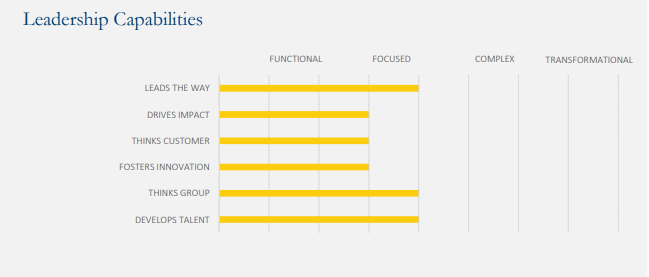

In [12]:
image_path = '/content/Sample_graph1.png'
# image_path = '/content/drive/MyDrive/freelance/1sample_graph_edited.png'
img = cv2.imread(image_path)
cv2_imshow(img)

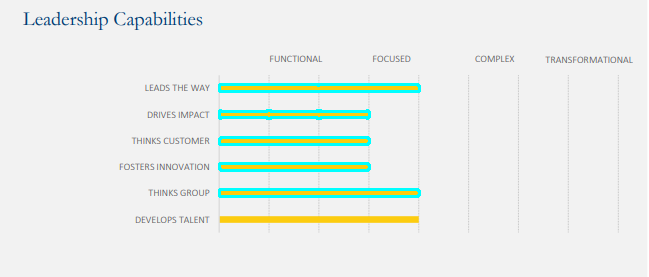

In [13]:
bars = calc_contours(image_path)
contours_right_coords = get_topright_corner(bars[::-1])

In [17]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2
!pip install -e.

Cloning into 'detectron2'...
remote: Enumerating objects: 15508, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 15508 (delta 66), reused 178 (delta 42), pack-reused 15275
Receiving objects: 100% (15508/15508), 6.39 MiB | 13.60 MiB/s, done.
Resolving deltas: 100% (11181/11181), done.
/content/detectron2
Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 926.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post2022

In [14]:
image = Image.open(image_path)

feature_extractor,tokenizer,model = loadFromLayoutlmv2()

id2label, label2color = labelForBoxes()


output_image, boxes,words,true_predictions,true_boxes,is_subword = process_image(image,id2label,label2color,feature_extractor,tokenizer,model)

words_to_bbox = merge_close_words(words,boxes,image)
bboxes = list(words_to_bbox.values())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/802M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for nielsr/funsd contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nielsr/funsd
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [15]:
words_to_boxes = merge_close_words(words,boxes,image)
bboxes = list(words_to_boxes.values())
bboxes.insert(0, [0.0,0.0,0.0,0.0])
bboxes.append( [0.0,0.0,0.0,0.0])
words_d = [list(words_to_boxes.keys())]

updated_categorized_data = graph_categorizer(words_d,bboxes,image)
updated_words_to_bboxes = merge_close_words(words,boxes,image)
contours_right_coords = get_topright_corner(bars[::-1])

contour_to_values = nearest_assignment(updated_categorized_data,updated_words_to_bboxes,contours_right_coords)

sub_output = assign_value_to_keys(updated_categorized_data,updated_words_to_bboxes,contours_right_coords,contour_to_values)


In [16]:
output = {"header": updated_categorized_data['headers'], "Mapping":sub_output}
output

{'header': ['Leadership', 'Capabilities'],
 'Mapping': {'WAY': None, 'Dives': None, '"THINKS': None, 'FOSTERS': None}}

In [17]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install -q pytesseract

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.8.0+cu101 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+c

In [18]:

!pip install transformers
!pip install datasets

In [19]:

!sudo apt-get install tesseract-ocr
!pip install -q pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [83]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pytesseract

from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2ForTokenClassification
from datasets import load_dataset
from PIL import Image, ImageFont, ImageDraw

In [84]:
def get_condional_bbox(image_path):
  img = cv2.imread(image_path)


  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Apply a thresholding operation to convert the image to a binary image
  thresh_value = 60
  ret, thresh = cv2.threshold(gray, thresh_value, 255, cv2.THRESH_BINARY)

  # Find the contours in the binary image
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # filtering out the unwanted contours
  new_contours = []
  for cnt in contours:
      area = cv2.contourArea(cnt)
      x, y, w, h = cv2.boundingRect(cnt)
      aspect_ratio = float(w) / h
      if area < 100000  and area > 10000:
          new_contours.append(cnt)
  # Draw all the contours on a blank image
  contour_img = np.zeros_like(img)
  cv2.drawContours(contour_img, new_contours, -1, (0, 255, 0), 2)

  # Filterring out the unwanted contours again
  bboxes = [new_contours[0][idx].tolist()[0] for idx in range(len(new_contours[0])) if idx in [0,3,4,8]]

  return bboxes

In [85]:
def loadFromLayoutlmv2():

  feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")# apply_ocr is set to True by default
  tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased")
  model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
  return feature_extractor,tokenizer,model

def labelForBoxes():
    dataset = load_dataset("nielsr/funsd", split="test")
    # define id2label, label2color
    labels = dataset.features['ner_tags'].feature.names
    id2label = {v: k for v, k in enumerate(labels)}
    return id2label

# Define label2color outside the function
label2color = {'question': 'blue', 'answer': 'green', 'header': 'orange', 'other': 'violet'}



def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label
def process_image(image,id2label,label2color,feature_extractor,tokenizer,model):
    # Convert the image to RGB format
    image = image.convert('RGB')
    width, height = image.size

    # get words, boxes
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    words, boxes = encoding_feature_extractor.words, encoding_feature_extractor.boxes
    # encode
    encoding = tokenizer(words, boxes=boxes, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    encoding["image"] = encoding_feature_extractor.pixel_values
    # forward pass
    outputs = model(**encoding)
    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
        feature_extractor, tokenizer, model = loadFromLayoutlmv2()

    return image,true_boxes,words,true_predictions,true_boxes,is_subword
    # Now call process_image with the correct arguments
    output_image, boxes, words, true_predictions, true_boxes, is_subword = process_image(image, id2label, feature_extractor, tokenizer, model)
    boxes = boxes[1:-1]


In [86]:
def normalize_bbox(bboxes,img):

  # Define the new image size
  new_width = 100
  new_height = 100

  original_width,original_height = img.size
  # Calculate the scaling factors
  x_scale = new_width / original_width
  y_scale = new_height / original_height

  #parsing the bboxes
  new_bboxes = []
  for bbox in bboxes:
    x1,y1,x2,y2 = bbox
    # Normalize the bounding box coordinates
    new_x1 = int(x1 * x_scale)
    new_y1 = int(y1 * y_scale)
    new_x2 = int(x2 * x_scale)
    new_y2 = int(y2 * y_scale)

    new_bbox = new_x1,new_y1,new_x2,new_y2
    new_bboxes.append(new_bbox)
  return new_bboxes


In [87]:

######### categorize the words into "headers"

def get_the_header(words,bboxes,img):

  output_dict = {"headers":[],"values":[]}

  bboxes = normalize_bbox(bboxes,img)

  prev_y1 = bboxes[0][1]
  header = None
  for idx in range(len(words[0])):
    x1,y1,x2,y2 = bboxes[idx]
    ###### header
    diff = abs(prev_y1 - y1)
    if(diff>20):
      break
    if(header==None):
      header = words[0][idx]
      continue
    header = header + ' ' + words[0][idx]
    prev_y1 = y1
  return header


In [88]:

def words_inside_bbox(words,text_boxes,cond_bbox):
  c_x1 , c_y1, c_x2, c_y2 = float(cond_bbox[0][0]), float(cond_bbox[0][1]), float(cond_bbox[1][0]),float(cond_bbox[2][1])
  # print(c_x1 , c_y1, c_x2, c_y2,'\n\n')
  out_word = None
  ## parse the words
  for idx in range(len(words)):
    x1,y1,x2,y2 = text_boxes[idx]
    x1,y1,x2,y2 = round(x1,2),round(y1,2),round(x2,2),round(y2,2)
    # print(words[idx], x1,y1,x2,y2)

    # x1>=c_x1 and x2<=c_x2 and y1>=c_y1 and y2<=c_y2
    if(x1>=c_x1 and x2<=c_x2 and y1>=c_y1 and y2<=c_y2):
        # print(words[idx], x1,y1,x2,y2 )
        if(out_word==None):
          out_word = words[idx]
          continue
        out_word += " " + words[idx]

  # print(out_word)
  return out_word


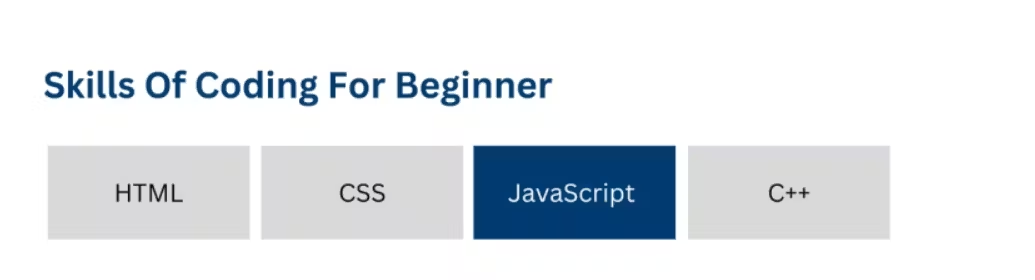

In [89]:
# Load the image
image_path = '/content/drive/MyDrive/freelance/graph_2/1sample_graph_enhanced.png'  # (535, 1051, 3)
image_path = '/content/drive/MyDrive/freelance/graph_2/global_market_benchmark_enhanced.png' # (328, 1711, 3)
image_path = '/content/drive/MyDrive/freelance/graph_2/leadership_capability_enhanced.png'
image_path = '/content/input_Bar2.png'
# image_path =
image = Image.open(image_path)
image


In [90]:

try:
  import os
  os.mkdir('/content/output_images')
except:
  pass


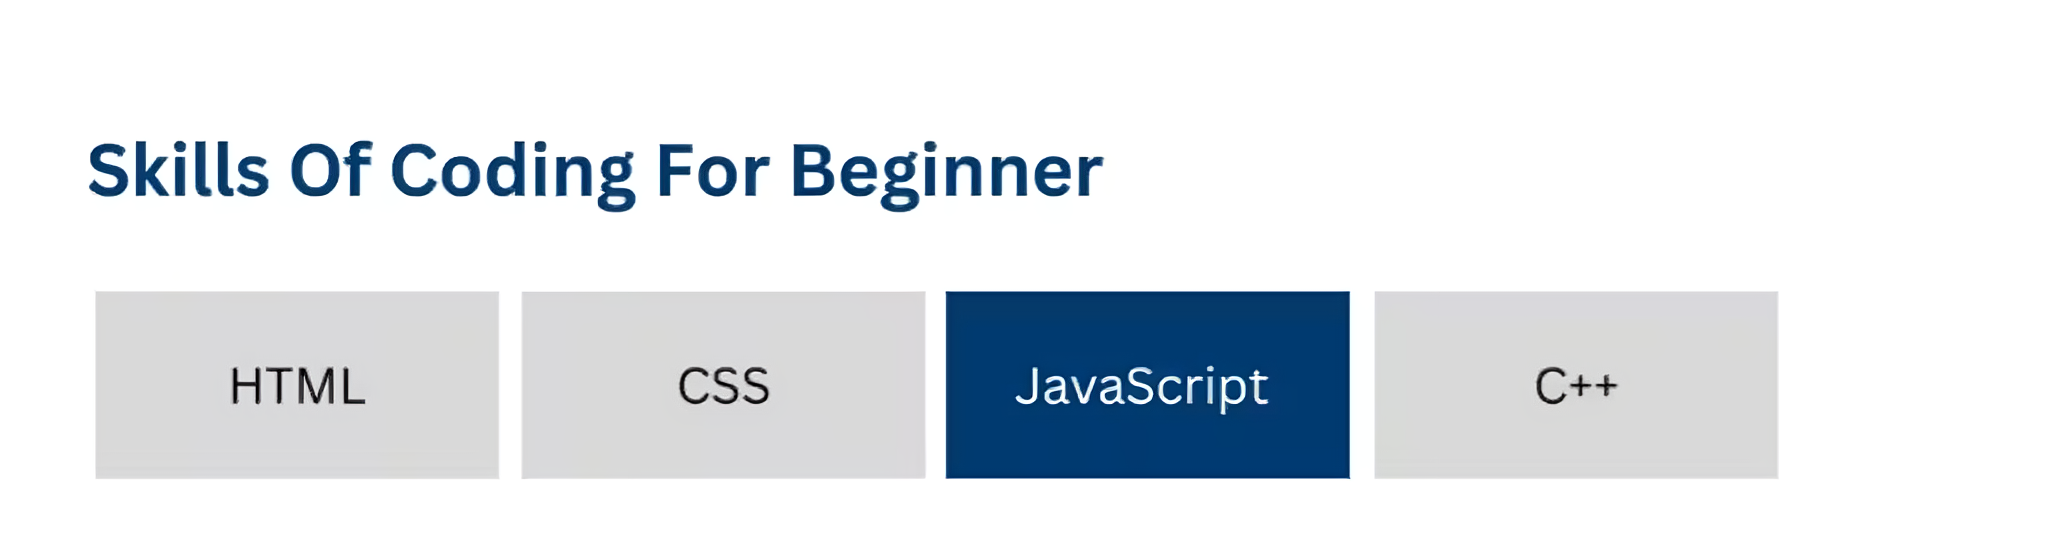

In [91]:
import requests
response = requests.post(
  'https://www.cutout.pro/api/v1/matting?mattingType=18',
  files={'file': open(image_path, 'rb')},
  headers={'APIKEY': '04c68d378bf84b71a63d7afe20ab20b1'},
)
with open('/content/output_images/out.png', 'wb') as out:
  out.write(response.content)

image_path = '/content/output_images/out.png'
img = cv2.imread(image_path)
cv2_imshow(img)

In [92]:
cond_boxes = get_condional_bbox(image_path)

In [69]:

output_image, boxes,words,true_predictions,true_boxes,is_subword = process_image(image,id2label,label2color,feature_extractor,tokenizer,model)
boxes = boxes[1:-1]


/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [93]:

output_word = words_inside_bbox(words[0],boxes,cond_boxes)

header = get_the_header(words,boxes,image)

In [94]:

output = {header:output_word}
output

{'Passionate': None}